<a href="https://colab.research.google.com/github/sv650s/amazon-review-classification/blob/master/notebooks/deep_learning/5.3-lstm-1-and-5-stars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTMB 1-star and 5-star only

In this notebook, we will review results of LSTMB network with 16 units.

In order to debug our network and see how much noise we are introducing to the network with middle classes (2, 3, 4). We are going to train the network with only 1-star and 5-star reviews only

All runs use the same 16 unit LSTM architecture with balanced weights and GloVe pre-trained embedding

We will compare our model scores with models that were trained with all 5 star-rating classes.

# Notebooks

* [6.6.1-LSTMB16_15-GloVe-200k-prototype.ipynb](deep_learning/6.6.1-LSTMB16_15-GloVe-200k-prototype.ipynb)
* [6.6.2-LSTMB16_15-GloVe-500k-prototype.ipynb](deep_learning/6.6.2-LSTMB16_15-GloVe-500k-prototype.ipynb)
* [6.6.3-LSTMB16_15-GloVe-1m-prototype.ipynb](deep_learning/6.6.3-LSTMB16_15-GloVe-1m-prototype.ipynb)
* [6.6.4-LSTMB16_15-GloVe-2m-prototype.ipynb](deep_learning/6.6.4-LSTMB16_15-GloVe-2m-prototype.ipynb)

# Results

Model is doing really well when classifying only 1 and 5 star reviews

Our Score is around 0.95 with small improvements as we increase the number of examples

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
DRIVE_DIR = "drive/My Drive/Springboard/capstone"
sys.path.append(DRIVE_DIR)


%tensorflow_version 2.x


import tensorflow as tf
# checl to make sure we are using GPU here
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow 2.x selected.


''

In [0]:
# import sibling utilities
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import importlib
from datetime import datetime

import util.dict_util as du
import util.report_util as ru
import util.plot_util as pu
import util.keras_util as ku

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set(font_scale=2)
pd.set_option("max_colwidth", 200)


DEBUG = False

if DEBUG == True:
  TRAIN_SIZE = 101008
else:
  # this the model with the largest sample we can load. 
  # For some reason kernal dies when I save a 2m model always
  TRAIN_SIZE = 505410


MAX_SEQUENCE_LENGTH = 100
LABEL_COLUMN = "star_rating"
REVIEW_COLUMN = "review_body"


In [3]:
import importlib
importlib.reload(ru)

REPORT_DIR = f"{DRIVE_DIR}/reports"
REPORT_LSTM_GLOVE = f'{REPORT_DIR}/glove_embedding-dl_prototype-report.csv'


report_glove = pd.read_csv(REPORT_LSTM_GLOVE, quotechar="'")
report_glove = ru.convert_dnn_report_format(report_glove)
report_glove.train_examples = np.round(report_glove.train_examples).astype(int)

lstm_glove = report_glove[report_glove.model_name == "LSTMB16"]
lstm_glove["eval_metric"] = lstm_glove.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))

lstm_glove15 = report_glove[report_glove.model_name == "LSTMB16_15"]
lstm_glove15["eval_metric"] = lstm_glove15.classification_report.apply(lambda x: \
                                                                       ru.calculate_metric15(json.loads(x)))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


# Model Performance

NOTE: Because we are filtering out 2, 3, 4 star reviews. When we train with the same initial sample size files, once filtered the number of traning examples is much smaller. Hence the shorter orange line in the graph. For instance, with a 2mil inital sample file, once filtered down, total training sample size went down to 1352517

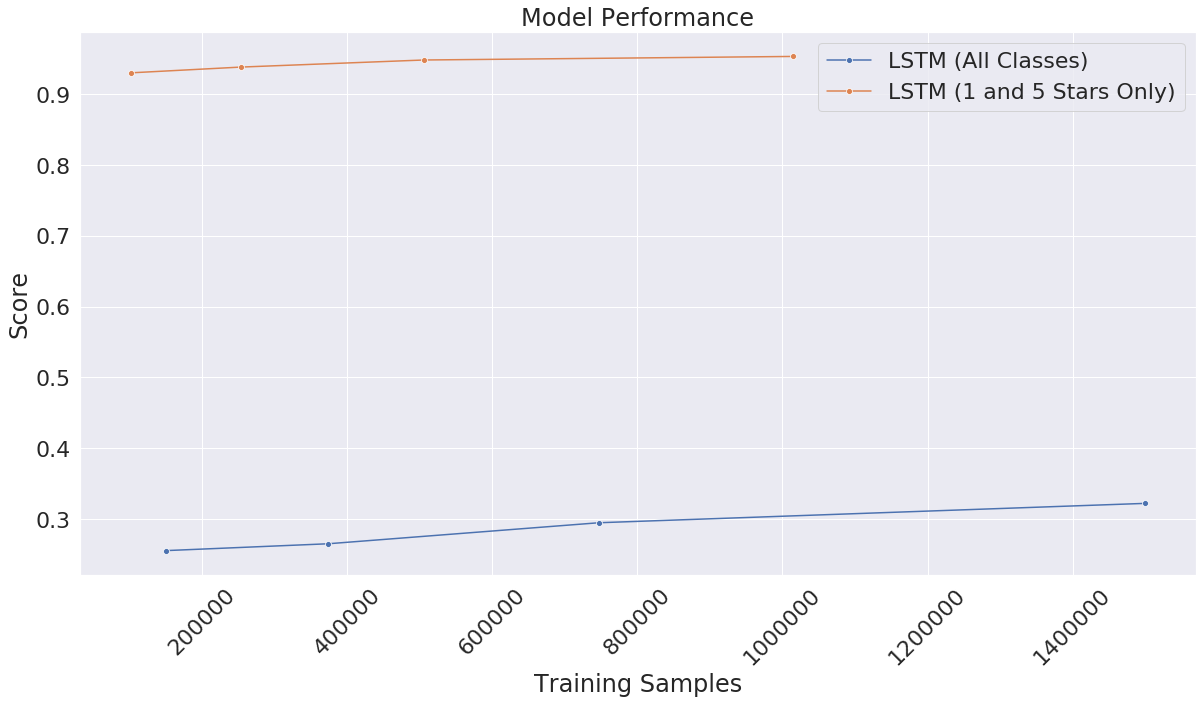

In [4]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=lstm_glove, x="train_examples", y="eval_metric", 
             marker="o", label="LSTM (All Classes)")
sns.lineplot(data=lstm_glove15, x="train_examples", y="eval_metric", 
             marker="o", label="LSTM (1 and 5 Stars Only)")
_ = plt.xticks(rotation=45)
_ = plt.xlabel("Training Samples")
_ = plt.ylabel("Score")
_ = plt.title("Model Performance")




# Confusion Matrix and Classification Report

We will look at 2m samples

In [5]:
# load the report entry for our sample size
entry_2m = lstm_glove15[lstm_glove15.train_examples == TRAIN_SIZE]
entry_2m


,1_f1-score,1_precision,1_recall,1_support,2_f1-score,2_precision,2_recall,2_support,3_f1-score,3_precision,3_recall,3_support,4_f1-score,4_precision,4_recall,4_support,5_f1-score,5_precision,5_recall,5_support,accuracy,architecture,batch_size,class_weight,classification_report,confusion_matrix,description,embedding,epochs,evaluate_time_min,feature_set_name,file,loss,macro avg_f1-score,macro avg_precision,macro avg_recall,macro avg_support,max_sequence_length,model_file,model_json_file,model_name,network_history_file,predict_time_min,roc_auc,sampling_type,status,status_date,test_examples,test_features,tokenizer_file,train_examples,train_features,train_time_min,weighted avg_f1-score,weighted avg_precision,weighted avg_recall,weighted avg_support,weights_file,eval_metric
8,0.925178,0.930437,0.919978,35053.0,0.980481,0.979038,0.981929,133418.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.969039,1x16,128.0,"[2.4074572904534963, 0.6310645335291165]","{""1"": {""precision"": 0.9304365388499379, ""recall"": 0.9199783185462015, ""f1-score"": 0.9251778746844158, ""support"": 35053}, ""2"": {""precision"": 0.9790377544614832, ""recall"": 0.981928975100811, ""f1-sco...","[[32248, 2805], [2411, 131007]]","1 Layer 16 (1 and 5 star rating only) LSTM Units, No Dropout, GloVe Embedding, Balanced Weights",300.0,13.0,0.61,glove,drive/My Drive/Springboard/capstone/data/amazon_reviews_us_Wireless_v1_00-1m-preprocessed.csv,0.087616,0.95283,0.954737,0.950954,168471.0,100.0,drive/My Drive/Springboard/capstone/models/LSTMB16_15-1x16-glove-sampling_none-673881-100-star_rating-model.h5,drive/My Drive/Springboard/capstone/models/LSTMB16_15-1x16-glove-sampling_none-673881-100-star_rating-model.json,LSTMB16_15,drive/My Drive/Springboard/capstone/reports/LSTMB16_15-1x16-glove-sampling_none-673881-100-star_rating-history.pkl,0.42,"{""auc_1"": 0.991486317237537, ""auc_2"": 0.9914863239730539, ""auc_micro"": 0.9947537353033742, ""auc_macro"": 0.9914903136171945}",none,success,2020-02-14 08:44:07,168471.0,100.0,drive/My Drive/Springboard/capstone/models/LSTMB16_15-1x16-glove-sampling_none-673881-100-star_rating-tokenizer.pkl,505410,100.0,10.72,0.968975,0.968926,0.969039,168471.0,drive/My Drive/Springboard/capstone/models/LSTMB16_15-1x16-glove-sampling_none-673881-100-star_rating-weights.h5,0.94859


In [6]:
# load and pring classification report
crd = json.loads(entry_2m.classification_report.values[0])
pd.DataFrame.from_dict(crd)

,1,2,accuracy,macro avg,weighted avg
precision,0.930437,0.979038,0.969039,0.954737,0.968926
recall,0.919978,0.981929,0.969039,0.950954,0.969039
f1-score,0.925178,0.980481,0.969039,0.952830,0.968975
support,35053.000000,133418.000000,0.969039,168471.000000,168471.000000


In [7]:
# load and print confusion matrix
pd.DataFrame(json.loads(entry_2m.confusion_matrix.values[0])).rename(
    { 0: 1, 1: 5}, axis=1
)

,1,5
0,32248,2805
1,2411,131007


# Look at Misclassified Samples

### First we have to load our dataset and convert to sequence like we did during training

In [0]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
import pickle



df = pd.read_csv(entry_2m.file.values[0])

df = df[(df[LABEL_COLUMN] == 1) | (df[LABEL_COLUMN] == 5)]
# have to set 5's to 2's so we can compute class weights later
df.loc[df[LABEL_COLUMN] == 5, LABEL_COLUMN] = 2
CLASSES = 2

rating = df[LABEL_COLUMN]
reviews = df[REVIEW_COLUMN]

y = OneHotEncoder().fit_transform(rating.values.reshape(len(rating), 1)).toarray()


# split our data into train and test sets
reviews_train, reviews_test, y_train, y_test = train_test_split(reviews, y, random_state=1)


# load tokenizer
with open(entry_2m.tokenizer_file.values[0], 'rb') as f:
  t = pickle.load(f)


test_sequences = t.texts_to_sequences(reviews_test)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [9]:
y_train[:5]


array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [10]:
X_test[-1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    9,    8,
         31,    5,   90,    2,   39,  298,  182,   17,  609,  372, 2674,
         57,   19,  120,   48, 2666,    6,   32,    2, 1959,  244,    7,
         11], dtype=int32)

# Load our Pre-trained Model

Our model accuracy from training was: 96.90%

see [6.6.4-LSTMB16_15-GloVe-2m-prototype.ipynb](deep_learning/6.6.4-LSTMB16_15-GloVe-2m-prototype.ipynb)

In [11]:
from tensorflow.keras.models import load_model

model = load_model(entry_2m.model_file.values[0])

scores = model.evaluate(X_test, y_test, verbose=1)



168471/168471 [==============================] - 75s 445us/sample - loss: 0.0876 - categorical_accuracy: 0.9690


In [12]:
print("Loss: %.2f%%" % (scores[0]*100))
print("Accuracy: %.2f%%" % (scores[1]*100))


Loss: 8.76%
Accuracy: 96.90%


# Use our model to make predictions

In [13]:
y_predict = model.predict(X_test)
y_predict[:5]

array([[2.4396912e-03, 9.9756026e-01],
       [1.1910465e-04, 9.9988091e-01],
       [1.1148667e-03, 9.9888510e-01],
       [6.6868518e-04, 9.9933136e-01],
       [2.2128834e-05, 9.9997783e-01]], dtype=float32)

In [14]:
y_test_unencoded = ku.unencode(y_test)
y_predict_unencoded = ku.unencode(y_predict)

from sklearn.metrics import confusion_matrix, classification_report

cr = classification_report(y_test_unencoded, y_predict_unencoded)
print(cr)

confusion_matrix = confusion_matrix(y_test_unencoded, y_predict_unencoded)
print(confusion_matrix)

              precision    recall  f1-score   support

           1       0.93      0.92      0.93     35053
           2       0.98      0.98      0.98    133418

    accuracy                           0.97    168471
   macro avg       0.95      0.95      0.95    168471
weighted avg       0.97      0.97      0.97    168471

[[ 32248   2805]
 [  2411 131007]]


# Create a Dataframe with Our Label and Prediction

In [15]:
result = pd.DataFrame({"test": y_test_unencoded, "predict": y_predict_unencoded})

# there is an extra step here to change 2's to 5's since we had to change this while training
# to get our encoders and class weights to work
result.test = result.test.map({1: 1, 2: 5}).astype(int)
result.predict = result.predict.map({1: 1, 2: 5}).astype(int)

# add column to tell use which ones are misclassified
result["correct"] = result.test == result.predict

result.sample(5)

,test,predict,correct
53053,5,5,True
13114,1,1,True
155829,5,5,True
132516,1,1,True
109470,1,1,True


In [0]:
# reset reviews index so it matches our result dataframe and we can use the index
# of incorrect entries to look up review body
reviews_reset = reviews_test.reset_index().rename({"index": "index_orig"}, axis=1)

# 1-Star Reviews Classified as 5-Star

In [17]:
incorrect_result = result[(result.test == 1) & (result.correct == False)]
incorrect_idx = incorrect_result.index.tolist()
incorrect_pd = pd.merge(incorrect_result, 
                        reviews_reset.loc[incorrect_idx], 
                        left_index = True, 
                        right_index = True)
incorrect_pd.sample(min(20, len(incorrect_result)), random_state=1)

,test,predict,correct,index_orig,review_body
53444,1,5,False,891775,arrived no hole microphone prevented microphone phone working replacement camera cutout wrong place need come 1 4 came 1 8 cover fit phone would not kept anyway did not like textured surface made ...
22582,1,5,False,588937,charger will not fit samsung galaxy active unless willing cut bottom usb mini jack cover jack cover prevents charger male connector fitting far enough phone jack make good connection can not bend ...
52406,1,5,False,524324,order use box shave side fine like cheap corded though do eventually fail best thing do still straight apple
75283,1,5,False,625482,got pink case ordered mint case besides would great would 5 star
81277,1,5,False,709615,tried could not get rid bubble spend bit buy techarmor competitor instead actually follow installation instruction
154527,1,5,False,26428,cute doe stick glass cell fun stick friend pas
97619,1,5,False,624506,granted got use another device tablet concept should able pas power plug another usb device however doe not let power
1473,1,5,False,833358,could not get bubble film regardless much took cc smooth gave hour trying smooth
150537,1,5,False,752399,needed car charger galaxy nexus did not work phone car phone husband car phone car phone car finally ran combination phone car realized five buck plus side led charger lit car would like tiny 5 li...
110593,1,5,False,348944,thought really hard put got quite bubble remove glass also really thick never glass screen protector though may comparable others


# 5-Star Reviews Classified as 1-Star

In [18]:
incorrect_result = result[(result.test == 5) & (result.correct == False)]
incorrect_idx = incorrect_result.index.tolist()
incorrect_pd = pd.merge(incorrect_result, reviews_reset.loc[incorrect_idx], left_index = True, right_index = True)
incorrect_pd.sample(min(20, len(incorrect_result)), random_state=1)

,test,predict,correct,index_orig,review_body
65642,5,1,False,797195,do neiping touch screen accidentally damaged touch screen sad can not use phone
163309,5,1,False,49151,work difficult day able trust called bargain case honestly say received deal card came quickly via priorty mail minute loaded minute text data triple minute android phone do not pas deal
61882,5,1,False,615303,hated getting elbow sleeve stuck longer antenna work much shorter no snag
102822,5,1,False,737288,ordered white atmosphere case very good looking case right size doe not make phone thick providing enough protection bad thing case white edge case starting turn yellow case week
93101,5,1,False,910963,phone battery really getting worn taking long charge not lasting very long bought battery external charger rotate two battery process actually corrected problem old battery
90563,5,1,False,718941,nothing positive comment completely satisfied required word making little unhappy review
12136,5,1,False,258666,dont data plan fit need phone txt wifi enabled
135193,5,1,False,407168,said issue top left corner not working issue realized not screen protector put protector phone pull mine reapply 3 ti ames get right realized did not perfectly centered top corner would stay unatt...
87225,5,1,False,614386,first several seller got mine cara k company recommend packaged well small bubble wrap mailer tool one baggie speaker another speaker also enclosed little plastic protective cube protect others sa...
138245,5,1,False,301335,loved however use lifeproof case iphone 4 unable utilize big case drats


In [19]:
print(datetime.now())

2020-02-15 01:38:18.375158
